In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras import Model
from keras.applications import vgg19 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from skimage import transform

In [3]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [6]:
Y_train = to_categorical (y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [7]:
X_train = np.array([transform.resize(x, (48, 48)) for x in X_train])
X_val = np.array([transform.resize(x, (48, 48)) for x in X_val])
X_test = np.array([transform.resize(x, (48, 48)) for x in X_test])

In [9]:
base_model = vgg.VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

80134624/80134624 [==============================] - 13s 0us/step


In [10]:
last = base_model.get_layer('block3_pool').output

In [11]:
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [12]:
for layer in base_model.layers:
     layer.trainable = False

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [16]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [17]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [19]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 27s 12ms/step - loss: 0.3138 - accuracy: 0.2886 - val_loss: 0.2472 - val_accuracy: 0.4428
Epoch 2/40
1328/1328 [==============================] - 16s 12ms/step - loss: 0.2553 - accuracy: 0.4124 - val_loss: 0.2262 - val_accuracy: 0.4941
Epoch 3/40
1328/1328 [==============================] - 15s 12ms/step - loss: 0.2384 - accuracy: 0.4599 - val_loss: 0.2147 - val_accuracy: 0.5192
Epoch 4/40
1328/1328 [==============================] - 16s 12ms/step - loss: 0.2272 - accuracy: 0.4920 - val_loss: 0.2071 - val_accuracy: 0.5393
Epoch 5/40
1328/1328 [==============================] - 17s 13ms/step - loss: 0.2198 - accuracy: 0.5096 - val_loss: 0.2014 - val_accuracy: 0.5532
Epoch 6/40
1328/1328 [==============================] - 17s 12ms/step - loss: 0.2133 - accuracy: 0.5273 - val_loss: 0.1961 - val_accuracy: 0.5628
Epoch 7/40
1328/1328 [==============================] - 16s 12ms/step - loss: 0.2087 - accuracy: 0.5387 - val_loss: 0.1924 -

In [20]:
import pickle 

history_file_path = 'vgg19_training_history.pkl'

with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_file_path)

Training history saved to: vgg19_training_history.pkl


In [21]:
model.save("vgg19_model.keras")

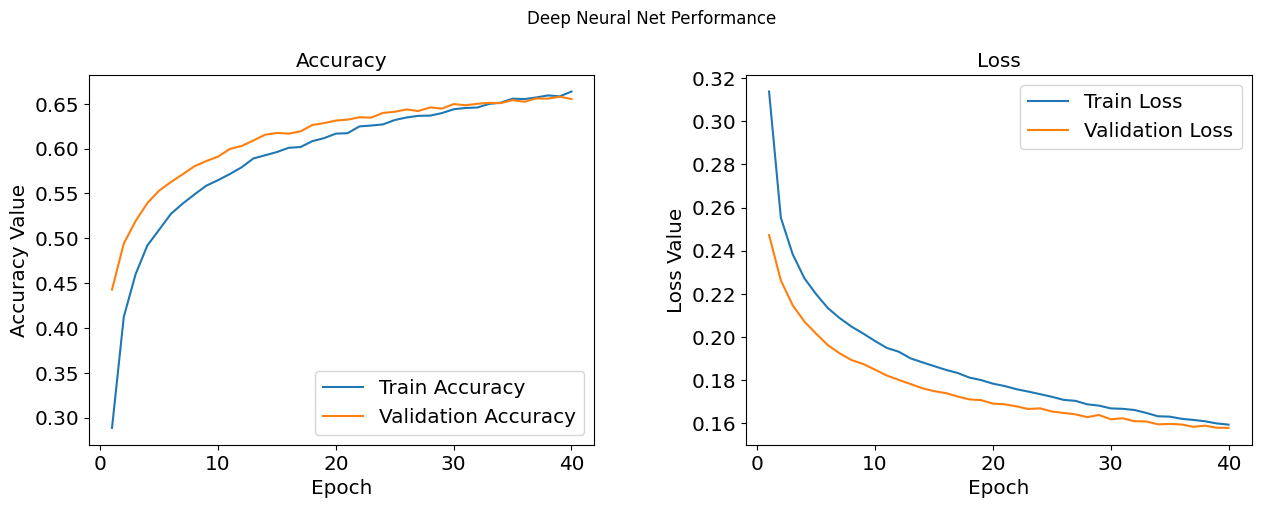

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 3s 9ms/step


In [24]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [25]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.6491
Precision: 0.6499
Recall: 0.6491
F1 Score: 0.6473


In [26]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [27]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicited_label = np.argmax(predictions_array)
  if predicited_label == true_label:
     color = 'blue'
  else:
     colot = 'red'

  plt.xlabel("{} {:2.0f} ({})".format(label_dict[predicted_label],
                                      100*np.max(predictions_array),
                                      label_dict[true_label],
                                      color=color))

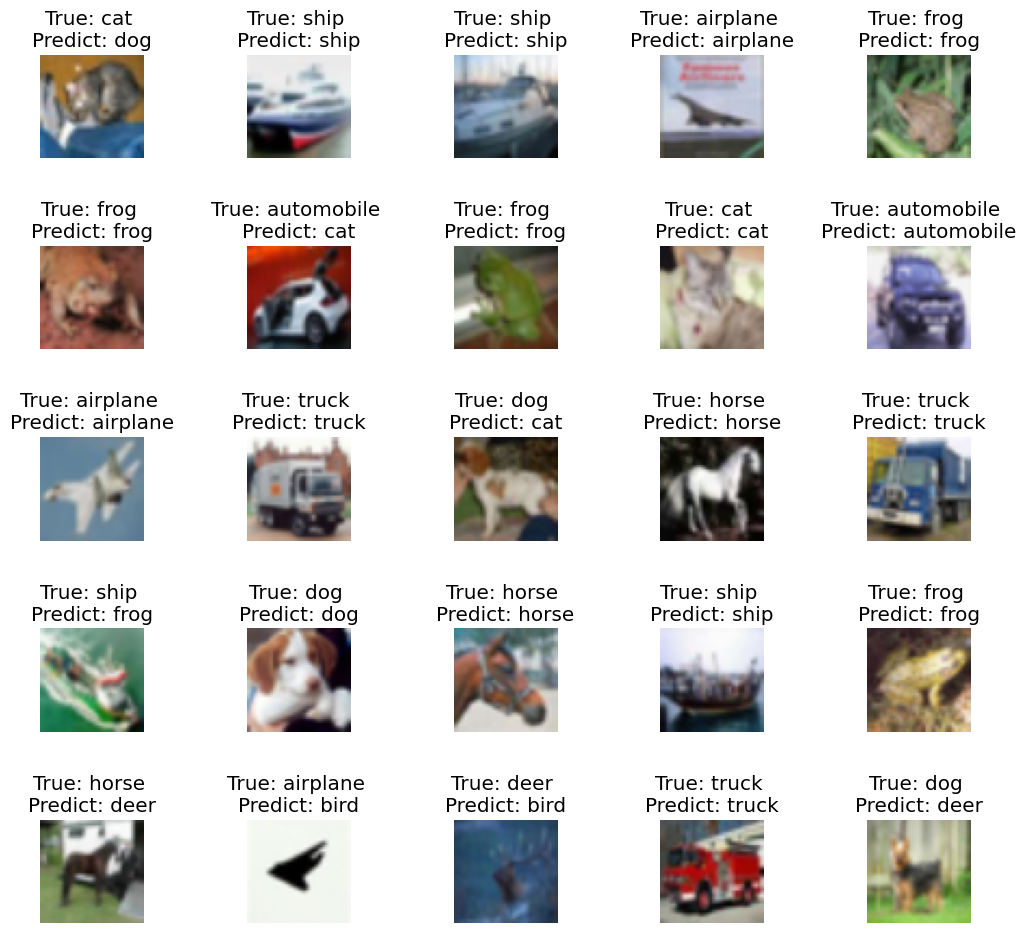

In [28]:
R = 5
C = 5

fig, ax = plt.subplots(R,C,figsize=(12,12))
ax = ax.ravel()

for i in np.arange(0, R*C):
  ax[i].imshow(X_test[i])
  ax[i].set_title("True: {} \nPredict: {}".format(label_dict[np.argmax(Y_test[i])], label_dict[predictions[i]]))
  ax[i].axis('off')
  plt.subplots_adjust(wspace=1)